# Data Exploration

## Import Libries

In [ ]:
#For runnig the both notebook I recomand google Colab pro with 35 GB RAM

In [3]:
# !pip install emoji

In [4]:
# !python -m spacy download en_core_web_md

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import emoji
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import spacy


## Load train data original

In [6]:
df_train = pd.read_excel('train.xlsx')
df_train_reviews = pd.read_excel('train_reviews.xlsx')

In [7]:
df_train.head()

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [8]:
df_train_reviews.head()

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


## Load test data original

In [9]:
df_test_reviews = pd.read_excel('test_reviews.xlsx')
df_test = pd.read_excel('test.xlsx')

In [10]:
df_test_reviews.head()

,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...
3,1,We've been in Lisbon in march 2013 (3 adults a...
4,1,Our host Antonio was very helpful with informa...


In [11]:
df_test.head()

,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
3,4,Charming Apartment Close to the Bay of Cascais...,:)
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


### Merge data train set

In [12]:
#change the type of comments column to str
df_train_reviews['comments'] = df_train_reviews['comments'].astype(str)

#group comments by index
df_train_reviews_new = df_train_reviews.groupby('index')['comments'].apply('\n'.join).reset_index()

#save the result into a new csv file
df_train_reviews_new.to_csv("train_reviews_new.csv", index=False)


In [13]:
#load the data into a dataframe
df_train_reviews_new = pd.read_csv('train_reviews_new.csv')

#print the dataframe
df_train_reviews_new

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,5,Un très bel appartement avec une magnifique vu...
2,8,Shani was very helpful throughout our process!...
3,9,Nous avons passé un très bon séjour chez Isabe...
4,10,"WOW, what a great stay! The spacious apartment..."
...,...,...
8462,12490,Excellent very well equiped apartment! Thank y...
8463,12491,I am so happy to found this accomodation near ...
8464,12492,Appartement très bien situé en plein coeur du ...
8465,12493,"Nice place, nice location, easy communication!..."


In [14]:
#merge description and host_about in one column

df_train['description & host'] = df_train['description'].astype(str) + df_train['host_about'].astype(str)

#remove  description and host_about from train dataset
df_train = df_train.drop(['description', 'host_about'], axis=1)

#merged df_train with df_train_reviews_new after index
merged_df = df_train.merge(df_train_reviews_new[['comments', 'index']], on='index', how='left')

#set index column as index
merged_df.set_index('index',inplace=True)

#where is missing comment fill with  emty space to avoid error when is merging everything
merged_df['comments'].fillna('', inplace=True)

#merged all text in one column

merged_df['text'] = merged_df['description & host'] + ' ' + merged_df['comments']

#drop old column
merged_df = merged_df.drop(['comments', 'description & host'], axis=1)

#check the dataset
merged_df

,unlisted,text
index,,
1,0,"This is a shared mixed room in our hostel, wit..."
2,1,"O meu espaço fica perto de Parque Eduardo VII,..."
3,1,Trafaria’s House is a cozy and familiar villa ...
4,0,"Apartamento Charmoso no Chiado, Entre o Largo ..."
5,0,Joli appartement en bordure de mer.<br /> 2 m...
...,...,...
12492,0,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...
12493,0,Beautifully located in the heart of Lisbon's h...
12494,0,Enjoy breakfast in the sleek kitchen with its ...


### Merge data test set

In [15]:
#change the type of comments column to str
df_test_reviews['comments'] = df_test_reviews['comments'].astype(str)

#group comments by index
df_test_reviews_new = df_test_reviews.groupby('index')['comments'].apply('\n'.join).reset_index()

#save the result into a new csv file
df_test_reviews_new.to_csv("test_reviews_new.csv", index=False)

In [16]:
#load the dataframe
test_reviews_new=pd.read_csv('test_reviews_new.csv')


In [17]:
df_test

,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
3,4,Charming Apartment Close to the Bay of Cascais...,:)
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...
...,...,...,...
1384,1385,O melhor ponto de partida para descobrir Lisbo...,I work in Hospitality and I love traveling._x0...
1385,1386,Casa de Baixo is a cozy and comfortable apartm...,"Visit us, stay with us and discover the most b..."
1386,1387,Beautiful and peaceful apartment with a superb...,"Nice, well travelled, educated, cult, cosmopol..."
1387,1388,The apartment in Lisbon has capacity for 2 pe...,We are Feels Like Home Holiday Rentals.\nA com...


In [18]:
#merged df_test with test_reviews_new by index
merged_df_test = df_test.merge(test_reviews_new[['comments', 'index']], on='index', how='left')

#fill with empty space where is mising commnet
merged_df_test['comments'].fillna('', inplace=True)

#merged all text in a single column text
merged_df_test['text'] = merged_df_test['description'] + ' ' + merged_df_test['host_about']+' '+merged_df_test['comments']

#drop the old columns
merged_df_test = merged_df_test.drop(['comments', 'description','host_about'], axis=1)

#set index column as index
merged_df_test.set_index('index',inplace=True)

In [19]:
merged_df_test

,text
index,
1,<b>The space</b><br />Apartment located in the...
2,"IMPORTANT: In response to COVID-19, this prope..."
3,"Bright, beautiful, and spacious. This four-bed..."
4,Charming Apartment Close to the Bay of Cascais...
5,"Se procura umas férias perto da praia, casino ..."
...,...
1385,O melhor ponto de partida para descobrir Lisbo...
1386,Casa de Baixo is a cozy and comfortable apartm...
1387,Beautiful and peaceful apartment with a superb...


In [20]:
# Save the DataFrame to a CSV file
merged_df_test.to_csv('merged_df_test.csv', index=False)

### Exploratory Analysis

In [21]:
merged_df

,unlisted,text
index,,
1,0,"This is a shared mixed room in our hostel, wit..."
2,1,"O meu espaço fica perto de Parque Eduardo VII,..."
3,1,Trafaria’s House is a cozy and familiar villa ...
4,0,"Apartamento Charmoso no Chiado, Entre o Largo ..."
5,0,Joli appartement en bordure de mer.<br /> 2 m...
...,...,...
12492,0,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...
12493,0,Beautifully located in the heart of Lisbon's h...
12494,0,Enjoy breakfast in the sleek kitchen with its ...


In [22]:
(merged_df['unlisted']).max()

1

In [23]:
(merged_df['unlisted']).min()

0

In [24]:
(merged_df['unlisted']).mean()

0.27712868117797695

In [25]:
(merged_df['unlisted']).std()

0.4475984896418051

In [26]:
(merged_df['unlisted']).median()

0.0

In [27]:
(merged_df['unlisted']).unique()

array([0, 1])

In [28]:
merged_df['unlisted'].describe()

count    12496.000000
mean         0.277129
std          0.447598
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: unlisted, dtype: float64

<Axes: >

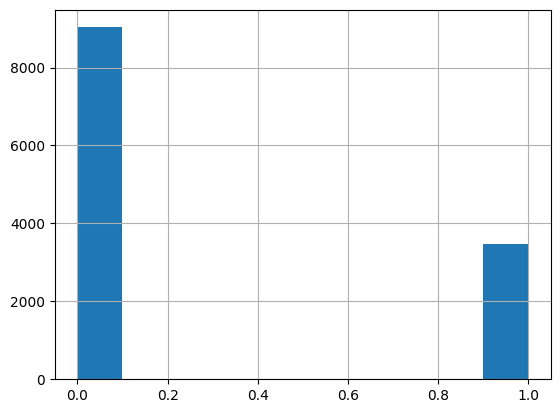

In [29]:
merged_df['unlisted'].hist()

<Axes: >

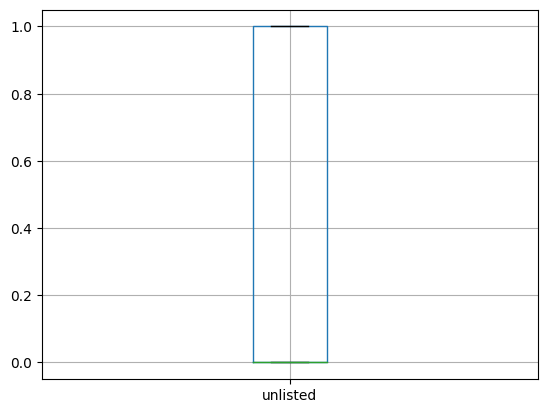

In [30]:
merged_df.boxplot(['unlisted'])

In [31]:
merged_df['unlisted'].isna().sum()

0

### Text (Independent features)

In [32]:
merged_df['text'][10]

"Walk up original wooden stairs to the entrance of an apartment bathed in light. Here, wooden fixtures rest atop hardwood floors and are accentuated by bold blues and vibrant plant life. Play a game on the tennis court and dive into the pool.<br /><br /><b>License number</b><br />80419/ALServiced holiday apartments casa in Azenhas do Mar combining the amenities of a luxury hotel with the space and privacy of your own vacation house. WOW, what a great stay! The spacious apartment is brand new with a super nice interior and the best view over the ocean. The light that falls into the rooms is so special at different times of the day, it is simply magic! It really felt like home from the very first moment, the house by the sea you always dreamt of. A coastal walk starts right at the property, which leads you to Azenhas do Mar in just a few minutes (beach, restaurants, but no supermarket). We enjoyed a breathtaking sunset with a glass of wine right by the pool. The beds are MEGA comfy and a

In [33]:
merged_df['text'].isna().sum()

0

### Word Count

In [34]:
merged_df['word_count']  = merged_df['text'].apply(lambda x: len(str(x).split(" ")))
merged_df[['text','word_count']].head()

,text,word_count
index,,
1,"This is a shared mixed room in our hostel, wit...",1412
2,"O meu espaço fica perto de Parque Eduardo VII,...",47
3,Trafaria’s House is a cozy and familiar villa ...,215
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",78
5,Joli appartement en bordure de mer.<br /> 2 m...,1161


### Descriptive Statistics of word count

In [35]:
merged_df.word_count.describe()

count    12496.000000
mean      2918.676056
std       4490.149054
min          4.000000
25%        234.000000
50%        952.500000
75%       3676.250000
max      55963.000000
Name: word_count, dtype: float64

<Axes: >

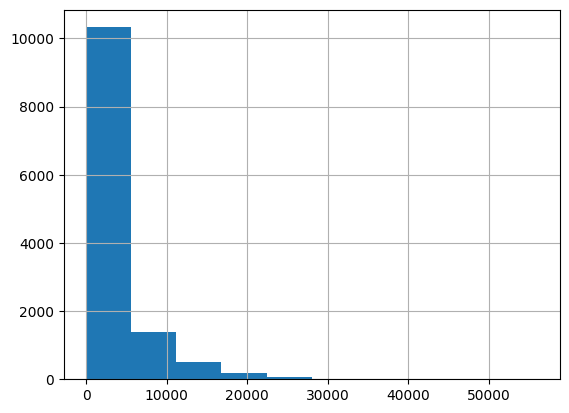

In [36]:
merged_df['word_count'].hist()

In [37]:
all_words = ' '.join(merged_df['text']).split()

In [38]:
freq = pd.Series(all_words).value_counts()

In [39]:
freq.sort_values(ascending=False)[0:10]

and     1185846
the     1112345
a        864741
to       710262
in       544837
is       542807
was      479209
of       390681
very     316491
de       304938
dtype: int64

In [40]:
freq.index[0:10]

Index(['and', 'the', 'a', 'to', 'in', 'is', 'was', 'of', 'very', 'de'], dtype='object')

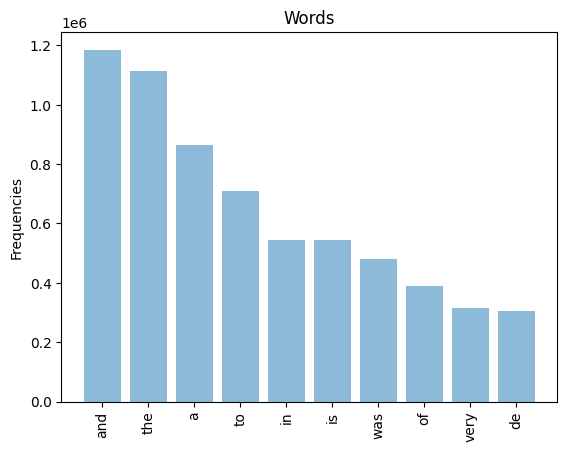

In [41]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
# plt.xticks(y_pos, x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

# Data Preprocessing

In [42]:
nltk.download('stopwords')

stopwords_list = []
for lang in ['english', 'spanish', 'french', 'russian', 'chinese', 'portuguese', 'german', 'italian']:
    stopwords_list += stopwords.words(lang)

print(stopwords_list)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [43]:

nltk.download('wordnet')

lemma = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [44]:

def clean(text_list, lemmatize, stemmer):
    updates = []
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)

    for j in tqdm(text_list):
        text = j

        # REMOVE EMOJIS
        text = emoji_pattern.sub(r'', text)

        # LOWERCASE TEXT
        text = text.lower()

        # REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub("br", "", text)

        # REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stopwords_list])

        # LEMMATIZE
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())

        # STEMMING
        if stemmer:
            text = " ".join(stemmer.stem(word) for word in text.split())

        updates.append(text)

    return updates

In [45]:
updates = clean(merged_df['text'], lemmatize=True, stemmer=False)



100%|██████████| 12496/12496 [11:01<00:00, 18.90it/s]


In [46]:
updates[10]

'dear guest pleaser receive home one guest room people living home space tv netflix mbo w private kitchen shared situated minute metro anjos min gra min walking city centre space good couple solo adventure business traveler b space b apartment typical characteristic house time wooden floor shutter window b guest access b neighborhood quiet walk without problem bus tram minute walk next apartment garage park around euro day b thing note b apartment situated quiet street lisbon close center minute walking grace alfama castelo metro anjos minute walking electric minute street cafe whi quiet person like cinema reading writing walking traveling love receive people need help respecting privacy interest sociologist cristina really perfect host helped lot trip house clean cozy min away center highly recommend house thanks everything way forgot lisbon magnet home please keep know may take next time logement tr bien situ proximit tro bus tram permet rendre tr facilement alfama peut pied chez cri

In [47]:
merged_df['text'][10]

"Walk up original wooden stairs to the entrance of an apartment bathed in light. Here, wooden fixtures rest atop hardwood floors and are accentuated by bold blues and vibrant plant life. Play a game on the tennis court and dive into the pool.<br /><br /><b>License number</b><br />80419/ALServiced holiday apartments casa in Azenhas do Mar combining the amenities of a luxury hotel with the space and privacy of your own vacation house. WOW, what a great stay! The spacious apartment is brand new with a super nice interior and the best view over the ocean. The light that falls into the rooms is so special at different times of the day, it is simply magic! It really felt like home from the very first moment, the house by the sea you always dreamt of. A coastal walk starts right at the property, which leads you to Azenhas do Mar in just a few minutes (beach, restaurants, but no supermarket). We enjoyed a breathtaking sunset with a glass of wine right by the pool. The beds are MEGA comfy and a

In [48]:
def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"text": list_updated}))

In [49]:
merged_df = merged_df.drop(['word_count'], axis=1)
update_df(merged_df, updates)
merged_df

,unlisted,text
index,,
1,0,espa fica perto parque eduardo vii saldanha es...
2,1,trafaria house cozy familiar villa facility ne...
3,1,apartamento charmoso chiado largo carmo traves...
4,0,joli appartement bordure mer min pied plage vu...
5,0,important response covid property extended cle...
...,...,...
12492,0,beautifully located heart lisbon historic cent...
12493,0,enjoy eakfast sleek kitchen freestanding knott...
12494,0,terra eira casa campo rodeada rvores fruto con...


In [50]:
updates2 = clean(merged_df_test['text'], lemmatize=True, stemmer=False)

100%|██████████| 1389/1389 [01:14<00:00, 18.56it/s]


In [51]:
updates2[10]

'quaint beautiful flat one lisbon trendiest area bairro alto oozing european charm lisbon historical city center ceramic tile covered stone building lay near must see bit western europe hottest destination bairro alto legendary bar restaurant district bar free street oasis peace quiet winding cobblestone street block tram min walk pr ncipe real min walk baixa chiado metro cais sodr b space b ur flat apartment building nearly two century old capture essence lisbon ancient history sitting center typical historical neighborhood occupies entire rd floor building th floor american standard full length narrow balcony affords view winding street glimpse tejo river flowing atlantic distance thousand meter hill hi jos live lisbon msc engineering physic student lisbon university managing great flat sure good time'

In [52]:
merged_df_test['text'][10]

'Gorgeous bright one bedroom with sunny balcony in the old town of Cascais offers visitors a real feel of local life. Located on a quiet green square with mature trees and benches. We receive sun in the morning and the afternoon and have lovely views over tree tops from the fully equipped kitchen. Modern bathroom with bath and shower.<br /><br /><b>The space</b><br />Renovated apartment in the old quarters.  The sunny west facing balcony offers you a chance to soak up a little sunshine or a nice evening meal. Airconditioning means you will feel warm in winter and cool in summer making this a great all year round place to stay.<br />Located on a quiet green square with mature trees and benches. The space is well organised with plenty of storage  and it is bright and airy.<br /><br /><b>Guest access</b><br />Access is via the main building door. Two flights of stairs - no lift.<br /><br />Parking: <br />Cascais station 24h: €15 Walk: 10m<br />Hipódromo de Cascais Av. República 553. 24h: 

In [53]:
update_df(merged_df_test, updates2)
merged_df_test

,text
index,
1,important response covid property extended cle...
2,ight beautiful spacious four bedroom apartment...
3,charming apartment close bay cascais bedroom d...
4,procura uma f rias perto praia casino outras a...
5,rustic house strong typical characteristic sit...
...,...
1385,casa baixo cozy comfortable apartment ideal fa...
1386,beautiful peaceful apartment superb view minim...
1387,apartment lisbon capacity people apartment hou...


In [54]:
# Load the pre-trained GloVe word vectors
nlp = spacy.load('en_core_web_md')

In [56]:
# Split the data into training and evaluation sets
X_train, X_eval, y_train, y_eval = train_test_split(merged_df['text'], merged_df['unlisted'], test_size=0.2, random_state=42)

In [57]:
# Save the DataFrame to a CSV file
X_train.to_csv('X_train.csv', index=False)

In [58]:
# Save the DataFrame to a CSV file
X_eval.to_csv('X_eval.csv', index=False)

In [59]:
# Save the DataFrame to a CSV file
y_train.to_csv('y_train.csv', index=False)

In [60]:
# Save the DataFrame to a CSV file
y_eval.to_csv('y_eval.csv', index=False)